##### Copyright 2021 The TensorFlow Quantum Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learning to supress noise with an entangling quantum generative adversarial network (EQ-GAN)

Author : Alexander Zlokapa

Created : 2021-Jun-23

Last updated : 2021-Jun-23

In this tutorial, we describe the [EQ-GAN architecture](https://arxiv.org/abs/2105.00080) and demonstrate its ability to mitigate common errors on near-term quantum hardware. Given an unknown state, the quantum neural network aims to learn a variational circuit that reproduces the state in the presence of an unknown noise model. While a perfect swap test is shown to converge to the incorrect state, the EQ-GAN successfully generates a state with lower error.

## Setup

Install TensorFlow and TensorFlow Quantum.

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-quantum

     |████████████████████████████████| 394.3MB 36kB/s 
     |████████████████████████████████| 471kB 39.3MB/s 
     |████████████████████████████████| 3.8MB 27.5MB/s 
     |████████████████████████████████| 2.9MB 26.1MB/s 
     |████████████████████████████████| 7.8MB 3.0MB/s 
     |████████████████████████████████| 1.3MB 41.2MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 5.6MB 18.9MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 1.5MB 41.8MB/s 
     |████████████████████████████████| 389kB 39.2MB/s 


Import TensorFlow, TensorFlowQuantum, and Cirq to perform both machine learning and quantum computing.

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Create the quantum circuits.
### 1.1 Define the quantum generator (and the quantum data)

We prepare a parameterized quantum circuit $G(\theta)$ that will serve as both our true data for particular parameters $\theta = \theta_0$ and as a generator for arbitrary $\theta$. For this example, we'll use a circuit that prepares a superposition of $|0\rangle$ and $|1\rangle$ states with some rotation between them. It can also be extended to multiple qubits using $CZ$ entangling gates, since Google's quantum hardware uses $CZ$ as a native gate.

In [ ]:
def generator_circuit(qubits, rotations):
    """Make a GHZ-like state with arbitrary phase using CZ gates.
    For the purposes of the noise experiment, we don't apply Z phase
    corrections, since the point is to match the generator and data
    gate parameters to know that there's high state overlap.

    Args:
        qubits: Python `lst` of `cirq.GridQubit`s
        rotations: Python `lst` indicating the X half rotations, Y half
            rotations and Z half rotations.
    """
    if len(rotations) != 3:
        raise ValueError("Number of needed rotations is 3.")
    
    u = [cirq.Z(qubits[0])**rotations[0],
        cirq.X(qubits[0])**rotations[1],
        cirq.Z(qubits[0])**rotations[2]]
    for q0, q1 in zip(qubits, qubits[1:]):
        u.extend([cirq.Y(q1)**0.5, cirq.X(q1), cirq.CZ(q0, q1),
                  cirq.Y(q1)**0.5, cirq.X(q1)])
    return cirq.Circuit(u)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


One-qubit example generator:


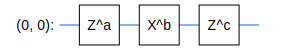

In [ ]:
print('One-qubit example generator:')
SVGCircuit(generator_circuit(cirq.GridQubit.rect(1, 1),
                  [sympy.Symbol('a'), sympy.Symbol('b'), sympy.Symbol('c')]))

Two-qubit example generator:


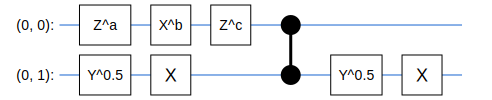

In [ ]:
print('Two-qubit example generator:')
SVGCircuit(generator_circuit(cirq.GridQubit.rect(1, 2),
                  [sympy.Symbol('a'), sympy.Symbol('b'), sympy.Symbol('c')]))

### 1.2 Define the discriminator circuit

For the discriminator circuit, we'll decompose a swap test circuit to use $CZ$ two-qubit gates. Since the predominant source of error on a $CZ$ gate is single-qubit $Z$ phase, we'll include $RZ$ rotations directly after the $CZ$ gate. A successful discriminator would learn how to correct the phase error by applying $RZ$ with an appropriate angle. In the case of "perfect" swap test (which is exactly a swap test in the absence of noise), the $RZ$ angles are fixed at zero.

In [ ]:
def discriminator_circuit(qubits_a, qubits_b, rotations):
    """Make a variational swap test circuit with CZ as the two-qubit gate.

    Args:
        qubits_a: Python `lst` of `cirq.GridQubit`s indicating subsystem A's
            qubits.
        qubits_b: Python `lst` of `cirq.GridQubit`s indicating subsystem B's
            qubits.
        rotations: Python `lst` of shape [n_qubits, 2] containing Z rotation
            parameters for the swap test.
    """
    if len(rotations) != len(qubits_a) or any(len(x) != 2 for x in rotations):
        raise ValueError("rotations must be shape [len(qubits_a), 2]")

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")
    
    u = []
    for i in range(len(qubits_a)):
        q0 = qubits_a[i]
        q1 = qubits_b[i]
        u.extend([cirq.Y(q1)**0.5, cirq.X(q1), cirq.CZ(q0, q1), cirq.Z(q0)**rotations[i][0], cirq.Z(q1)**rotations[i][1], cirq.Y(q1)**0.5, cirq.X(q1)])
    
    # expanded Hadamard: H = X Y^(1/2)
    for i, q in enumerate(qubits_a):
        u.append(cirq.Y(q)**0.5)
        u.append(cirq.X(q)**1.0)

    return cirq.Circuit(u)

Here's how the discriminator circuit looks when comparing two registers with one-qubit data.

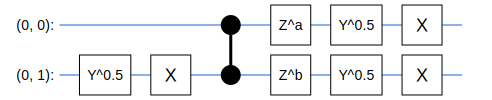

In [ ]:
SVGCircuit(discriminator_circuit([cirq.GridQubit(0, 0)], [cirq.GridQubit(0, 1)],
                  [[sympy.Symbol('a'), sympy.Symbol('b')]]))

To perform the ancilla-free swap test, we need some classical post-processing. This readout operation is described in the destructive swap test construction of the appendix.

In [ ]:
def swap_readout_op(qubits_a, qubits_b):
    """Readout operation for variational swap test.

    Computes the bitwise and of matched qubits from qubits_a and qubits_b.

    When the states have perfect overlap the expectation of this op will be -1
    when these states are orthogonal the expectation of this op will be 1.

    Args:
        qubits_a: Python `lst` of `cirq.GridQubit`s. The qubits system A act on
        qubits_b: Python `lst` of `cirq.GridQubit`s. The qubits system B act on
    """

    def _countSetBits(n):
        count = 0
        while n:
            count += n & 1
            n >>= 1
        return count

    def _one_proj(a):
        return 0.5 * (1 - cirq.Z(a))

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")

    ret_op = 0
    for i in range(1 << len(qubits_a)):
        if _countSetBits(i) % 2 == 0:
            tmp_op = 1
            for j, ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
                intermediate = _one_proj(qubits_a[j]) * _one_proj(qubits_b[j])
                if ch == '0':
                    intermediate = 1 - intermediate
                tmp_op *= intermediate
            ret_op += tmp_op

    return 1.0 - (ret_op * 2 - 1)

### 1.3 Create the noise model

We use Cirq to implement the noise model described above: each $CZ$ gate is followed by single-qubit $Z$ rotations that insert a phase error according to a Gaussian distribution. We'll also extend the noise model to include two-qubit phase errors, although our experiment will only include a single-qubit phase error.

In [ ]:
# add controlled phase and Z phase errors after each CZ gate
# CZ phase error is fully random
# Z phase error is always the same for a given qubit index
class CZNoiseModel(cirq.NoiseModel):
    def __init__(self, qubits, mean, stdev, seed=0):
        self.mean = mean
        self.stdev = stdev
        
        np.random.seed(seed)
        single_errors = {}
        for q in qubits:
            single_errors[q] = np.random.normal(self.mean[1], self.stdev[1])
        self.single_errors = single_errors
    
    def noisy_operation(self, op):
        if isinstance(op.gate, cirq.ops.CZPowGate):
            return [op, cirq.ops.CZPowGate(exponent=np.random.normal(self.mean[0], self.stdev[0]))(*op.qubits), cirq.ops.ZPowGate(exponent=self.single_errors[op.qubits[0]])(op.qubits[0]), cirq.ops.ZPowGate(exponent=self.single_errors[op.qubits[1]])(op.qubits[1])]
        
        return op

## 2. Create the quantum neural networks

We can now prepare TensorFlow Quantum objects from the Cirq circuits defined above. These will include the adversarial loss function, completing the definition of the EQ-GAN.

### 2.1 Utility functions
We prepare a series of functions to accesss the quantum data, generator, discriminator, and the number of parameters associated with each of those.

In [ ]:
def get_data_maker():
    """Get appropriate dataset maker for a given circuit type."""
    return generator_circuit

def get_circuit_maker():
    """Get appropriate circuit maker for a given circuit type."""
    return generator_circuit

def num_data_parameters(n_qubits):
    """Get number of true data circuit parameters for a circuit type."""
    return num_gen_parameters(n_qubits)

def num_gen_parameters(n_qubits):
    """Get number of generator model parameters for a circuit type."""
    return 3

def num_disc_parameters(n_qubits):
    """Get number of discriminator model parameters for a circuit type."""
    return 2*n_qubits

def get_rand_state(n_qubits, data_noise):
    """Get number of data preparation circuit parameters for a circuit type."""
    return np.random.uniform(-data_noise, data_noise, 
                             num_data_parameters(n_qubits))

When loading data in the quantum computer, it may be beneficial to augment the training set by adding noise (similarly to data augmentation in classical machine learning). Hence, our `generate_data` function takes a `data_noise` parameter that can create noisy copies of the original dataset. In our experiment below, however, we will set this to zero for simplicity.

In [ ]:
def generate_data(data_qubits, generator_qubits, target_quantum_data,
                  data_noise, noise_model, n_points):
    """Generate n_points data on data_qubits with generator_qubits linked for
    later copying."""
    data_maker = get_data_maker()

    target_circuits = []
    target_real_data_circuit = []

    rand_states = []
    for i in range(n_points):
        rand_states.append(get_rand_state(len(data_qubits), data_noise))
    for rand_state in rand_states:
        rand_circuit = data_maker(data_qubits, rand_state + target_quantum_data)
        rand_circuit_true_data_on_generator_qubit = data_maker(
            generator_qubits, rand_state + target_quantum_data)
        
        c_data = rand_circuit.with_noise(noise_model)
        c_gen = rand_circuit_true_data_on_generator_qubit.with_noise(noise_model)

        target_circuits.append(c_data)
        target_real_data_circuit.append(c_gen)
    target_circuits = tfq.convert_to_tensor(target_circuits)
    target_real_data_circuit = tfq.convert_to_tensor(target_real_data_circuit)

    return target_circuits, target_real_data_circuit

Finally, we require a custom `keras` layer to share variables between the discriminator and generator, since they represent two different quantum circuits.

In [ ]:
class SharedVar(tf.keras.layers.Layer):
    """A custom tf.keras.layers.Layer used for sharing variables."""
    def __init__(self, symbol_names, operators, init_vals, backend,
                 use_sampled):
        """Custom keras layer used to share tf.Variables between several
        tfq.layers.Expectation."""
        super(SharedVar, self).__init__()
        self.init_vals = init_vals
        self.symbol_names = symbol_names
        self.operators = operators
        self.use_sampled = use_sampled
        self.backend = backend

    def build(self, input_shape):
        # Build a tf.Variable that is the shape of the number of symbols.
        self.w = self.add_weight(shape=(len(self.symbol_names),),
                                 initializer=tf.constant_initializer(
                                     self.init_vals))

    def call(self, inputs):
        # inputs[0] = circuit tensor
        # inputs[1] = circuit tensor
        # Their expectations are evaluated with shared variables between them
        n_datapoints = tf.gather(tf.shape(inputs[0]), 0)
        values = tf.tile(tf.expand_dims(self.w, 0), [n_datapoints, 1])
        if not self.use_sampled:
            return tfq.layers.Expectation(backend=self.backend)(
                inputs[0],
                symbol_names=self.symbol_names,
                operators=self.operators,
                symbol_values=values), tfq.layers.Expectation(
                    backend=self.backend)(inputs[1],
                                          symbol_names=self.symbol_names,
                                          operators=self.operators,
                                          symbol_values=values)
        else:
            return tfq.layers.SampledExpectation(backend=self.backend)(
                inputs[0],
                symbol_names=self.symbol_names,
                operators=self.operators,
                symbol_values=values,
                repetitions=10000), tfq.layers.SampledExpectation(
                    backend=self.backend)(inputs[1],
                                          symbol_names=self.symbol_names,
                                          operators=self.operators,
                                          symbol_values=values,
                                          repetitions=10000)

### 2.2 Build the generator

The generator model includes both the quantum data and the quantum generator circuit, so that the data and model can later be *entangled* together by the discriminator. To compute the generator loss, we append the generator circuit to the quantum data and then apply the entangling variational swap test discriminator. The expectation of the output can either be computed exactly (with `tfq.layers.Expectation`) or sampled (with `tfq.layers.SampledExpectation`) before being provided to the loss function

$$
\min_{\theta_g} \max_{\theta_d} [1 - D(\theta_d, G(\theta_g))],
$$

which is optimized with `keras`. By default, we choose Adam to optimize the generator circuit parameters.

In [ ]:
def build_generator(generator_qubits,
                    data_qubits,
                    generator_symbols,
                    lr,
                    generator_initialization,
                    noise_model,
                    backend=None,
                    use_sampled=False,
                    regularization=0.000001,
                    optimizer=None):
    """Build a generator tf.keras.Model using standard circuits.

    Args:
        generator_qubits: Python `lst` of `cirq.GridQubit`s indicating the
            qubits that the generator should use.
        data_qubits: Python `lst` of `cirq.GridQubit`s indicating the qubits
            that the data will arrive on.
        generator_symbols: Python `lst` of numbers or `sympy.Symbol`s
            to use in the ansatze used for the generator.
        lr: Python `float` the learning rate of the model.
        backend: Python object for the backend type to use when running quantum
            circuits.
        generator_initialization: `np.ndarray` of initial values to place
            inside of the generator symbols in the tensorflow managed
            variables.
        noise_model: `cirq.NoiseModel` to apply to circuits.
        use_sampled: Python `bool` indicating whether or not to use analytical
            expectation or sample based expectation calculation.
        regularization: Python `float` added as margin to an orthogonal swap test.
        optimizer: `tf.keras.optimizers` optimizer for training the circuit. Default
            is tf.keras.optimizers.Adam.
    """
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam
    
    # Input for the circuits that generate the quantum data from the source.
    signal_input = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)

    # Input for the swaptest circuits. These will have the variables from the
    # discriminator resolved into them.
    swap_test_input = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)

    data_and_generated = tfq.layers.AddCircuit()(signal_input,
                                                 append=generator_circuit(
                                                     generator_qubits,
                                                     generator_symbols).
                                                     with_noise(noise_model))

    # Append the variational swap test on to the data on data_qubits
    # and the "generated" data on generator_qubits.
    full_swaptest = tfq.layers.AddCircuit()(data_and_generated,
                                            append=swap_test_input)

    expectation_output = None
    if not use_sampled:
        expectation_output = tfq.layers.Expectation(backend=backend)(
            full_swaptest,
            symbol_names=generator_symbols,
            operators=swap_readout_op(generator_qubits, data_qubits),
            initializer=tf.constant_initializer(generator_initialization))

    else:
        expectation_output = tfq.layers.SampledExpectation(backend=backend)(
            full_swaptest,
            symbol_names=generator_symbols,
            operators=swap_readout_op(generator_qubits, data_qubits),
            initializer=tf.constant_initializer(generator_initialization),
            repetitions=10000)

    expectation_output = tf.add(expectation_output, tf.constant(regularization))
    log_output = tf.math.log(expectation_output)

    # Input is true data on data qubits, and swap_test_input for both qubits.
    qgan_g_model = tf.keras.Model(inputs=[signal_input, swap_test_input],
                                  outputs=[expectation_output, log_output])

    optimizerg = optimizer(learning_rate=lr)
    lossg = lambda x, y: tf.reduce_mean(y)
    qgan_g_model.compile(optimizer=optimizerg, loss=lossg, loss_weights=[0,1])

    return qgan_g_model

### 2.3 Build the discriminator

The discriminator is similar to the generator, except the loss function is multiplied by a minus sign to perform adversarial learning. To propagate the loss through the generator, we use the `SharedVar` defined above.

In [ ]:
def build_discriminator(generator_qubits,
                        data_qubits,
                        discriminator_symbols,
                        lr,
                        discriminator_initialization,
                        noise_model,
                        backend=None,
                        use_sampled=False,
                        regularization=0.000001,
                        optimizer=None):
    """Build a discriminator model.

    Args:
        generator_qubits: Python `lst` of `cirq.GridQubit`s indicating the
            qubits that the generator should use.
        data_qubits: Python `lst` of `cirq.GridQubit`s indicating the qubits
            that the data will arrive on.
        discriminator_symbols: Python `lst` of numbers or `sympy.Symbol`s
            to use in the ansatze used for the discriminator.
        lr: Python `float` the learning rate of the model.
        discriminator_initialization: `np.ndarray` of symbols to place
            inside of the discriminator symbols in the tensorflow managed
            variables.
        backend: Python object for the backend type to use when running quantum
            circuits.
        use_sampled: Python `bool` indicating whether or not to use analytical
            expectation or sample based expectation calculation.
        regularization: Python `float` added as margin to an orthogonal swap test.
        optimizer: `tf.keras.optimizers` optimizer for training the circuit. Default
            is tf.keras.optimizers.Adam.
    """
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam

    # True data on data_qubits.
    signal_input_d = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)

    # Generator data on generator_qubits.
    load_generator_data_d = tf.keras.layers.Input(shape=(),
                                                  dtype=tf.dtypes.string)

    # True data on generator_qubits.
    load_true_data_d = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)

    # Swap circuit with input.
    swap_test_input_d = tfq.layers.AddCircuit()(
        signal_input_d,
        append=discriminator_circuit(data_qubits, generator_qubits,
                                np.array(discriminator_symbols).reshape(-1, 2)).
                                with_noise(noise_model))
    

    # Swap test between the true data and generator.
    swaptest_d = tfq.layers.AddCircuit()(load_generator_data_d,
                                         append=swap_test_input_d)

    # Swap test between the true data and itself. Useful for how close to the
    # "true" swap test we are over time as we train.
    swapontruedata = tfq.layers.AddCircuit()(load_true_data_d,
                                             append=swap_test_input_d)

    tmp = SharedVar(discriminator_symbols,
                    swap_readout_op(generator_qubits, data_qubits),
                    discriminator_initialization, backend, use_sampled)
    expectation_output_d, expectation_output2 = tmp(
        [swaptest_d, swapontruedata])

    expectation_output_d = tf.add(expectation_output_d, tf.constant(regularization))
    log_discrim_dist = tf.math.log(tf.keras.backend.flatten(expectation_output_d))
    log_true_dist = tf.math.log(tf.keras.backend.flatten(expectation_output2))


    final_output = -log_discrim_dist

    qgan_d_model = tf.keras.Model(
        inputs=[signal_input_d, load_generator_data_d, load_true_data_d],
        outputs=[expectation_output_d, expectation_output2, final_output])

    optimizerd = optimizer(learning_rate=lr)

    # Difference between "generator vs true data" and "true vs true (given
    # we many not be doing a perfect swap test yet)"
    lossd = lambda x, y: -tf.reduce_mean(y)
    qgan_d_model.compile(optimizer=optimizerd, loss=lossd, loss_weights=[0,0,1])

    return qgan_d_model

## 3 Benchmark the EQ-GAN

We'll train the EQ-GAN and compare it to a "perfect" swap test, which has the same generator but a frozen discriminator. The perfect swap test is *imperfect* in the presence of noise, since it assumes fully calibrated quantum hardware. Since noise on hardware oscillates on the order of 10 minutes, it becomes difficult to perfectly calibrate $CZ$ gates everywhere; consequently, the incorrectly calibrated perfect swap test will likely converge to an incorrect state. An approach robust to incorrect noise models is helpful to learn variational circuits. Since the EQ-GAN has a Nash equilibrium at the location of a calibrated swap test, we expect it to properly converge.

### 3.1 Training the EQ-GAN and perfect swap test models

To track performance, we need to compare the generated state with the true data state. This exact state fidelity metric is computed in the absence of noise.

In [ ]:
def quantum_data_overlap(qubits, params_a, params_b):
    """Compute overlap of quantum data circuits with params_a and params_b."""
    sim = cirq.Simulator()
    circuit_maker = get_circuit_maker()
    data_maker = get_data_maker()
    circuit_a = circuit_maker(qubits, params_a)
    circuit_b = data_maker(qubits, params_b)
    res_a = sim.simulate(circuit_a)
    res_b = sim.simulate(circuit_b)
    overlap = np.abs(np.vdot(res_a.final_state_vector, res_b.final_state_vector))
    return overlap

Running an experiment consists of the following steps:
* *Initialize the generator quantum circuit.* We set all rotation angles to zero in the beginning.
* *Initialize the discriminator quantum circuit.* The perfect swap test has a discriminator frozen with the expected gate parameters (which does not correspond to a perfect swap test due to noise). The adversarial swap test has a discriminator also initialized to the circuit expected to be a true swap test; although the assumption is false due to noise, it provides a good guess to start training.
* *Train model(s).* To enhance training stability, adversarial training will be performed in two phases. In the first half, the discriminator is frozen to be equivalent to perfect swap test training. In the second half, the discriminator is trained adversarially, allowing the EQ-GAN to converge to a true swap test and correct the noise. Training the perfect swap test is equivalent to performing the first phase (frozen discriminator) for the duration of both adversarial phases.
* *Record training history.* We output the loss functions and state overlap with the true data, as well as the parameter history of the generator and discriminator.

This is implemented in `run_experiment` below.

In [ ]:
def run_experiment(d_learn, g_learn, d_epoch, g_epoch, batchsize, n_episodes,
                   n_qubits, target_quantum_data, use_perfect_swap,
                   gate_error_mean, gate_error_stdev, n_data=1, data_noise=0,
                   use_sampled=False, log_interval=10, backend=None, seed=0):
    """Run a QGAN experiment.

    Args:
        d_learn: Python `float` discriminator learning rate.
        g_learn: Python `float` generator learning rate.
        d_epoch: Python `int` number of discriminator iterations per episode.
        g_epoch: Python `int` number of generator iterations per episode.
        batchsize: Python `int` number of entries to use in a batch.
        n_episodes: Python `int` number of total QGAN training episodes.
        n_qubits: Python `int` number of qubits to use for each susbsystem.
        target_quantum_data: Python object. True target state.
        use_perfect_swap: `bool` whether or not to train discriminator.
        gate_error_mean: mean angle error on 2-qubit gates (`None` if no noise).
        gate_error_stdev: standard deviation of angle error on 2-qubit gates.
        n_data: Python `int` number of total datapoints to generate.
        data_noise: Python `float` bounds on noise in real data preparation.
        use_sampled: Python `bool` whether or not analytical or sampled exp.
        backend: None or `cirq.SimulatesFinalState` or `cirq.Sampler`.
        log_interval: Python `int` log every log_interval episodes.
        seed: seed of run for noise model and training.
    """

    circuit_maker = get_circuit_maker()
    generator_initialization = np.zeros(num_gen_parameters(n_qubits))
    discriminator_initialization = np.array([[0.0, 0.0]] * n_qubits)
        
    # Create data and generator qubits
    data_qubits = [cirq.GridQubit(1, k + 4) for k in range(n_qubits)]
    generator_qubits = [cirq.GridQubit(2, k + 4) for k in range(n_qubits)]
    ancilla = cirq.GridQubit(1, 5)  # potentially unused.
    all_qubits = data_qubits + generator_qubits
    
    # Noise on single-qubit gates
    if (gate_error_mean is None) or (gate_error_stdev is None):
        noise_model = None
    else:
        noise_model = CZNoiseModel(all_qubits, gate_error_mean, gate_error_stdev, seed=seed)

    # Generator and Discriminator symbols
    discriminator_parameters = []
    generator_parameters = []
    for j in range(num_disc_parameters(n_qubits)):
        discriminator_parameters.append(sympy.Symbol('Discrimx{!r}'.format(j)))
    for j in range(num_gen_parameters(n_qubits)):
        generator_parameters.append(sympy.Symbol('Genx{!r}'.format(j)))
    target_circuits, target_real_data_circuit = generate_data(data_qubits,
        generator_qubits, target_quantum_data, data_noise, noise_model, n_data)

    # Generator and Discriminator models
    qgan_d_model = build_discriminator(
        generator_qubits, data_qubits, discriminator_parameters, d_learn,
        discriminator_initialization, noise_model, backend, use_sampled)
    qgan_g_model = build_generator(
        generator_qubits, data_qubits, generator_parameters, g_learn,
        generator_initialization, noise_model, backend, use_sampled)

    # Tracking info
    d_loss = []
    g_loss = []
    overlap_record = []
    param_history = []
    
    repeats = 1
    if not use_perfect_swap: # introduce adversarial second phase
        repeats = 2
        n_episodes = n_episodes // 2

    for r in range(repeats):
        if r == 0: # use perfect swap for first half
            use_perfect_swap = True
        elif r == 1: # use adversarial learning for second half
            use_perfect_swap = False
        # begin training
        for k in range(1, n_episodes + 1):
            if k != 0:
                generator_initialization = qgan_g_model.trainable_variables[
                    0].numpy()

            overlap_record.append(
                quantum_data_overlap(data_qubits, generator_initialization,
                                     target_quantum_data))
            param_history.append([qgan_g_model.trainable_variables[0].numpy(), 
                                 qgan_d_model.trainable_variables[0].numpy()])

            if not use_perfect_swap:
                # prepare discriminator network input
                gen_circuit = circuit_maker(generator_qubits, generator_initialization)
                gen_circuit = gen_circuit.with_noise(noise_model)
                load_generator_circuit = tf.tile(
                    tfq.convert_to_tensor(
                        [gen_circuit]),
                    tf.constant([n_data]))

                historyd = qgan_d_model.fit(x=[
                    target_circuits, load_generator_circuit, target_real_data_circuit
                ],
                                            y=[
                                                tf.zeros_like(target_circuits,
                                                              dtype=tf.float32),
                                                tf.zeros_like(target_circuits,
                                                           dtype=tf.float32),
                                                tf.zeros_like(target_circuits,
                                                           dtype=tf.float32)
                                            ],
                                            epochs=d_epoch,
                                            batch_size=batchsize,
                                            verbose=0)

                d_loss.append(historyd.history['loss'])

                # prepare generator network input
                discriminator_initialization = qgan_d_model.trainable_variables[
                    0].numpy().reshape((-1, 2))

            # evaluate noisy swap test
            swap_test_circuit = discriminator_circuit(
                data_qubits, generator_qubits, discriminator_initialization)

            swap_test_circuit = swap_test_circuit.with_noise(noise_model)
            swap_test_circuit = tf.tile(tfq.convert_to_tensor([swap_test_circuit]),
                                        tf.constant([n_data]))

            # record history
            history = qgan_g_model.fit(x=[target_circuits, swap_test_circuit],
                                       y=[tf.zeros_like(target_circuits,
                                                       dtype=tf.float32),tf.zeros_like(target_circuits,
                                                       dtype=tf.float32)],
                                       epochs=g_epoch,
                                       batch_size=batchsize,
                                       verbose=0)

            g_loss.append(history.history['loss'])

            if k % log_interval == 0:
                print(f'Step = {k}. Overlap={overlap_record[-1]}')
                print(f'Step = {k}. g_loss={g_loss[-1]}')
                if not use_perfect_swap:
                    print(f'Step = {k}. d_loss={d_loss[-1]}')
                print(f'Step = {k}. gen_params={qgan_g_model.trainable_variables[0].numpy()}')
                print(f'Step = {k}. discrim_params={qgan_d_model.trainable_variables[0].numpy()}')
                
                print('-'*50)

    return np.array(g_loss), np.array(d_loss), np.array(overlap_record), np.array(param_history)

Finally, we evaluate the performance of the EQ-GAN and perfect swap test models in learning the quantum state $\frac{1}{\sqrt{2}(|0\rangle + |1\rangle)$. Realistic single-qubit phase noise is estimated from Fig. S2 of Google's [paper](https://arxiv.org/abs/2010.07965) on Fermi-Hubbard dynamics, and we set the two-qubit controlled phase error to zero. Experimentally, the two-qubit controlled phase error is much smaller than the single-qubit phase error, so this assumption is realistic.

In [ ]:
d_epoch = 1
g_epoch = 1
batchsize = 4

target_quantum_data = [0.0, 0.5, 0.5]

n_qubits = 1
d_learn = 0.01
g_learn = 0.01
n_episodes = 80

# format (radians): [controlled phase error, single-qubit Z phase error]
gate_error_mean = [0.0, 0.06]
gate_error_stdev = [0.005, 0.02]

In [ ]:
# we run with a "perfect" swap test that is imperfect due to noise
use_perfect_swap = True
print('TRAINING PERFECT SWAP TEST')
g_loss_perf, d_loss_perf, overlap_perf, params_perf = run_experiment(
                      d_learn, g_learn, d_epoch, g_epoch, batchsize,
                      n_episodes, n_qubits, target_quantum_data,
                      use_perfect_swap, gate_error_mean, gate_error_stdev)
print()

# we run with adversarial training to see noise get suppressed
use_perfect_swap = False
print('TRAINING ADVERSARIAL SWAP TEST')
g_loss_adv, d_loss_adv, overlap_adv, params_adv = run_experiment(
                      d_learn, g_learn, d_epoch, g_epoch, batchsize,
                      n_episodes, n_qubits, target_quantum_data,
                      use_perfect_swap, gate_error_mean, gate_error_stdev)

TRAINING PERFECT SWAP TEST
Step = 10. Overlap=0.7287916541099548
Step = 10. g_loss=[-0.7754115462303162]
Step = 10. gen_params=[-0.00283764 -0.10153843 -0.08077508]
Step = 10. discrim_params=[0. 0.]
--------------------------------------------------
Step = 20. Overlap=0.8095174431800842
Step = 20. g_loss=[-1.1870241165161133]
Step = 20. gen_params=[-0.00320345 -0.2109291  -0.18916626]
Step = 20. discrim_params=[0. 0.]
--------------------------------------------------
Step = 30. Overlap=0.9168037176132202
Step = 30. g_loss=[-2.1242780685424805]
Step = 30. gen_params=[ 0.01510484 -0.33290875 -0.31152907]
Step = 30. discrim_params=[0. 0.]
--------------------------------------------------
Step = 40. Overlap=0.9908996820449829
Step = 40. g_loss=[-4.5349602699279785]
Step = 40. gen_params=[ 0.04663827 -0.47101778 -0.430013  ]
Step = 40. discrim_params=[0. 0.]
--------------------------------------------------
Step = 50. Overlap=0.9881062507629395
Step = 50. g_loss=[-10.211024284362793]
Ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Step = 10. Overlap=0.7287916541099548
Step = 10. g_loss=[-0.7754115462303162]
Step = 10. gen_params=[-0.00283764 -0.10153843 -0.08077508]
Step = 10. discrim_params=[0. 0.]
--------------------------------------------------
Step = 20. Overlap=0.8095174431800842
Step = 20. g_loss=[-1.1870241165161133]
Step = 20. gen_params=[-0.00320345 -0.2109291  -0.18916626]
Step = 20. discrim_params=[0. 0.]
--------------------------------------------------
Step = 30. Overlap=0.9168037176132202
Step = 30. g_loss=[-2.1242780685424805]
Step = 30. gen_params=[ 0.01510484 -0.33290875 -0.31152907]
Step = 30. discrim_params=[0. 0.]
--------------------------------------------------
Step = 40. Overlap=0.9908996820449829
Step = 40. g_loss=[-4.5349602699279785]
Step = 40. gen_params=[ 0.04663827 -0.47101778 -0.430013  ]
Step = 40. discrim_params=[0. 0.]
--------------------------------------------------
Step = 10. Overlap=0.9954313635826111
Step = 10. g_loss=[-10.230671882629395]
Step = 10. d_loss=[-9.69649410

### 4.1 Comparison

To analyze performance, we plot the overlap between the generated state $\psi = G(\theta)|0\rangle$ and the true data state $\psi = G(\theta_0)|0\rangle$ over time. Since the models are initialized in the $|0\rangle$ state, the initial fidelity with the data $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ is $1/2$.

In the first half of training, the EQ-GAN and perfect swap test experience identical training, since both are being optimized with frozen discriminators. In the second half of training, the EQ-GAN is seen to generate a state closer to the true data state, while the perfect swap test stabilizes at the incorrect state. As with classical GANs, the quantum GAN naturally drifts away from the converged state after it has been obtained due to a vanishing gradient. To identify where the converged state is, we examine the loss function and select the lowest discriminator loss (dashed line).

In [ ]:
def stopping_ind(d_loss, smoothing_period=5):
    """Get overlap and parameters at minimum generator loss."""
    # simple moving average
    flattened_loss = np.array(d_loss).flatten()
    if smoothing_period > 1:
        smoothed = np.convolve(flattened_loss, np.ones(smoothing_period), 'valid') / smoothing_period
    else:
        smoothed = flattened_loss
    
    # find when the discriminator loss is lowest in the second half of training
    # this corresponds to when the GAN is most fooled by the fake data
    n_episodes = len(d_loss)*2
    best_ind = n_episodes//2 + np.argmin(smoothed)
    best_ind += smoothing_period // 2
    if best_ind >= n_episodes:
        best_ind = n_episodes - 1
    return best_ind

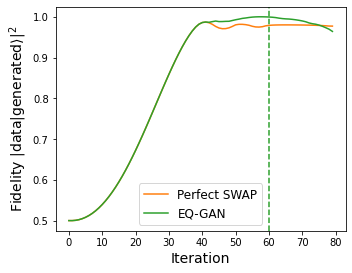

In [ ]:
fidelity_perfect_swap = overlap_perf**2
fidelity_adversarial = overlap_adv**2
adv_best_ind = stopping_ind(d_loss_adv, smoothing_period=5)

plt.figure(figsize=(5, 3.9))
plt.plot(fidelity_perfect_swap, 'C1', label='Perfect SWAP')
plt.plot(fidelity_adversarial, 'C2', label='EQ-GAN')
plt.axvline(x=adv_best_ind, c='C2', linestyle='--')
plt.legend(fontsize=12)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Fidelity $|\\mathrm{data} | \\mathrm{generated} \\rangle|^2$', fontsize=14)
plt.tight_layout()
plt.show()